In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

/tmp/ipykernel_399765/2730460777.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("./datasets/dataset_60k_window10k_L4_scaling3_diff.pth")


706.1536389561971


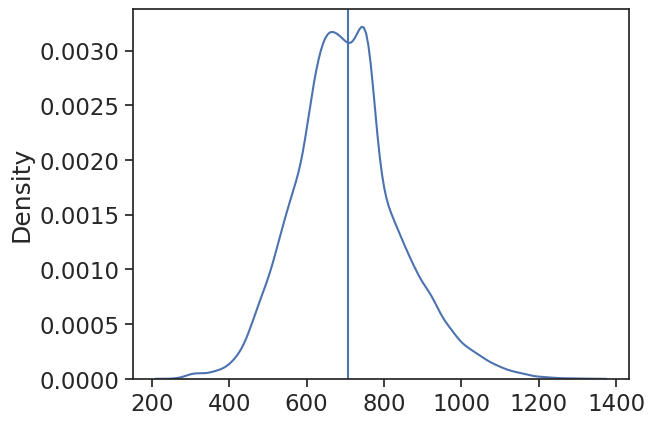

In [362]:
dataset = torch.load("./datasets/dataset_60k_window10k_L4_scaling3_diff.pth")
dataset = [(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) for X, y in dataset]
np.random.shuffle(dataset)
Xdist = [X.sum().item() for X, y in dataset]
sns.kdeplot(Xdist)
plt.axvline(np.mean(Xdist))
print(np.mean(Xdist))

In [6]:
def encode_minor_alleles_as_derived(alleles):
    allele_counts = Counter(alleles)
    min_allele = min(allele_counts, key=allele_counts.get)
    return [1 if allele == min_allele else 0 for allele in alleles]

def real_data2genotype_matrix_and_positions(data):
    num_segregating_sites = data.shape[0]
    for i in range(num_segregating_sites):
        data.loc[i,'alleles'] = str(encode_minor_alleles_as_derived(data['alleles'][i]))
    data = data[['chr', 'pos', 'alleles']]
    
    expanded_data = []
    for index, row in data.iterrows():
        chromosome = row['chr']
        position = row['pos']
        alleles = row['alleles'][1:-1].split(', ')  
        new_row = [chromosome, position] + alleles
        expanded_data.append(new_row)
    headers = ['chr', 'pos'] + [f'{i}' for i in range(len(alleles))]
    expanded_df = pd.DataFrame(expanded_data, columns=headers)
    
    positions = expanded_df['pos'].tolist()
    genotype_matrix = np.array(expanded_df.iloc[:, 2:].T).astype(np.int32)
    assert len(expanded_df['chr'].unique()) == 1
    return genotype_matrix, np.array(positions)

def real_genotype_matrix2transition_matrix(genotype_matrix, sequence_start, sequence_end , positions, window_size, num_samples = 10):
    empirical_scaling_factor = 3
    mask = np.logical_and(positions >= sequence_start, positions < sequence_end)

    genotype_matrix = genotype_matrix[:, mask]
    positions = positions[mask]

    combinations = binomial_combinations_k2(num_samples)
    sequence_length = int(sequence_end-sequence_start)
    Xs = []
    for sample_0, sample_1 in combinations:
        binary_genotype_matrix = genotype_matrix[[sample_0, sample_1]]

        sum_matrix = binary_genotype_matrix.sum(0)
        valid_mask = (sum_matrix < 2) & (sum_matrix > 0)
        binary_genotype_matrix = binary_genotype_matrix[:, valid_mask]
        binary_positions = positions[valid_mask]
        #print(binary_positions)

        full_sequence = np.zeros((2, int(sequence_length)), dtype=np.int32)
        full_sequence[:, binary_positions-int(sequence_start)] = binary_genotype_matrix
        #print(full_sequence.sum())
        X = obtain_densities(full_sequence, window_size=window_size)
        Xs.append(X)
    mutation_densities = torch.stack(Xs)
    tm = np.log(calculate_transition_matrix(np.log(mutation_densities.flatten()+1)*empirical_scaling_factor, np.log(population_time+1)) + 1)
    tm = torch.tensor(tm, dtype=torch.float32)
    return tm

def real_genotype_matrix2mutation_sequence(genotype_matrix, sequence_start, sequence_end , positions, window_size, num_samples = 10):
    empirical_scaling_factor = 3
    mask = np.logical_and(positions >= sequence_start, positions < sequence_end)

    genotype_matrix = genotype_matrix[:, mask]
    positions = positions[mask]

    combinations = binomial_combinations_k2(num_samples)
    sequence_length = int(sequence_end-sequence_start)
    Xs = []
    for sample_0, sample_1 in combinations:
        binary_genotype_matrix = genotype_matrix[[sample_0, sample_1]]

        sum_matrix = binary_genotype_matrix.sum(0)
        valid_mask = (sum_matrix < 2) & (sum_matrix > 0)
        binary_genotype_matrix = binary_genotype_matrix[:, valid_mask]
        binary_positions = positions[valid_mask]
        #print(binary_positions)

        full_sequence = np.zeros((2, int(sequence_length)), dtype=np.int32)
        full_sequence[:, binary_positions-int(sequence_start)] = binary_genotype_matrix
        #print(full_sequence.sum())
        X = obtain_densities(full_sequence, window_size=window_size)
        Xs.append(X)
    mutation_densities = torch.stack(Xs)
    return mutation_densities



In [7]:
import pandas as pd
from aTMi.misc import binomial_combinations_k2

In [8]:
# maf
data_snp_5mb = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_snps_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
data_smp_5mb = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])

In [9]:
from collections import Counter
from aTMi.processing import obtain_densities


In [10]:
sequence_starts = [0, 1.5e6]
sequence_ends = [1.5e6, 3e6]

mutation_densities_snps_complete_ibnr = []
mutation_densities_smps_complete_ibnr = []


for i in range(1):
    data_snp_5mb = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_snps_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
    gm_snp_5mb, positions_snp_5mb = real_data2genotype_matrix_and_positions(data_snp_5mb)
    data_smp_5mb = pd.read_csv("./Athaliana_maf/ibnr_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
    gm_smp_5mb, positions_smp_5mb = real_data2genotype_matrix_and_positions(data_smp_5mb)

    for l in range(2):
        sequence_start = sequence_starts[l]
        sequence_end = sequence_ends[l]

        mutation_densities_snps = real_genotype_matrix2mutation_sequence(
                gm_snp_5mb,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=positions_snp_5mb,
                window_size=20_000, num_samples=10)
        
        mutation_densities_smps = real_genotype_matrix2mutation_sequence(
                gm_smp_5mb,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=positions_smp_5mb,
                window_size=20_000, num_samples=10)
        
        mutation_densities_snps_complete_ibnr += mutation_densities_snps.flatten().tolist()
        mutation_densities_smps_complete_ibnr += mutation_densities_smps.flatten().tolist()

In [11]:
sequence_starts = [0, 1.5e6]
sequence_ends = [1.5e6, 3e6]

mutation_densities_snps_complete_ceu = []
mutation_densities_smps_complete_ceu = []


for i in range(1):
    data_snp_5mb = pd.read_csv("./Athaliana_maf/ceu_multihetsep_snps_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
    gm_snp_5mb, positions_snp_5mb = real_data2genotype_matrix_and_positions(data_snp_5mb)
    
    data_smp_5mb = pd.read_csv("./Athaliana_maf/ceu_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
    gm_smp_5mb, positions_smp_5mb = real_data2genotype_matrix_and_positions(data_smp_5mb)

    for l in range(2):
        sequence_start = sequence_starts[l]
        sequence_end = sequence_ends[l]

        mutation_densities_snps = real_genotype_matrix2mutation_sequence(
                gm_snp_5mb,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=positions_snp_5mb,
                window_size=20_000, num_samples=10)
        
        mutation_densities_smps = real_genotype_matrix2mutation_sequence(
                gm_smp_5mb,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=positions_smp_5mb,
                window_size=20_000, num_samples=10)
        
        mutation_densities_snps_complete_ceu += mutation_densities_snps.flatten().tolist()
        mutation_densities_smps_complete_ceu += mutation_densities_smps.flatten().tolist()

In [39]:
sequence_starts = [0, 1.5e6]
sequence_ends = [1.5e6, 3e6]

mutation_densities_smps_complete_11 = []

for i in range(1):
    data_smp_5mb = pd.read_csv("./Bd_maf/group1.1_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
    gm_smp_5mb, positions_smp_5mb = real_data2genotype_matrix_and_positions(data_smp_5mb)

    for l in range(2):
        sequence_start = sequence_starts[l]
        sequence_end = sequence_ends[l]

        mutation_densities_snps = real_genotype_matrix2mutation_sequence(
                gm_snp_5mb,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=positions_snp_5mb,
                window_size=20_000, num_samples=10)
        
        mutation_densities_smps = real_genotype_matrix2mutation_sequence(
                gm_smp_5mb,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=positions_smp_5mb,
                window_size=20_000, num_samples=10)
        
        mutation_densities_smps_complete_11 += mutation_densities_smps.flatten().tolist()


sequence_starts = [0, 1.5e6]
sequence_ends = [1.5e6, 3e6]

mutation_densities_smps_complete_12 = []

for i in range(1):
    data_smp_5mb = pd.read_csv("./Bd_maf/group1.2_multihetsep_smps_5mb_1", sep="\t", names=['chr', 'pos', 'space_prev_pos', 'alleles'])
    gm_smp_5mb, positions_smp_5mb = real_data2genotype_matrix_and_positions(data_smp_5mb)

    for l in range(2):
        sequence_start = sequence_starts[l]
        sequence_end = sequence_ends[l]
        
        mutation_densities_smps = real_genotype_matrix2mutation_sequence(
                gm_smp_5mb,
                sequence_start=sequence_start, sequence_end=sequence_end,
                positions=positions_smp_5mb,
                window_size=20_000, num_samples=10)
        
        mutation_densities_smps_complete_12 += mutation_densities_smps.flatten().tolist()

In [67]:
Xdist

[260.1883239746094,
 318.5205383300781,
 353.7956848144531,
 383.88641357421875,
 583.122314453125,
 432.87567138671875,
 469.2447814941406,
 476.731689453125,
 301.6424560546875,
 621.7393188476562,
 493.2107238769531,
 342.9560546875,
 456.1556091308594,
 639.3345336914062,
 385.9158630371094,
 416.9368591308594,
 293.08697509765625,
 599.1847534179688,
 339.3809814453125,
 321.7833251953125,
 454.7539978027344,
 545.1739501953125,
 439.9931945800781,
 287.8856506347656,
 371.20941162109375,
 320.6973876953125,
 526.8681640625,
 394.076904296875,
 596.2666625976562,
 365.4313049316406,
 595.1932983398438,
 600.2967529296875,
 465.5048522949219,
 455.14678955078125,
 468.0235900878906,
 574.5048828125,
 418.4558410644531,
 348.2874755859375,
 258.9248352050781,
 399.9275207519531,
 322.1898193359375,
 390.0359191894531,
 527.3533935546875,
 336.18328857421875,
 500.05255126953125,
 418.59326171875,
 453.2080383300781,
 391.7235107421875,
 607.3157958984375,
 328.5281677246094,
 399.05

In [40]:
mutation_densities_snps_complete_ceu = np.array(mutation_densities_snps_complete_ceu)
mutation_densities_smps_complete_ceu = np.array(mutation_densities_smps_complete_ceu)

mutation_densities_snps_complete_ibnr = np.array(mutation_densities_snps_complete_ibnr)
mutation_densities_smps_complete_ibnr = np.array(mutation_densities_smps_complete_ibnr)

mutation_densities_smps_complete_11 = np.array(mutation_densities_smps_complete_11)
mutation_densities_smps_complete_12 = np.array(mutation_densities_smps_complete_12)

Excellent thanks. Let’s remove the mean dotted red line from Fig 3C. Also, can you rearrange the panels so that Figure 3C is actually figure 3A and the rest follow. The Brachpodium results could follow as Figure 3D. I didn’t mean to compare it with SNPs like you did with Arabidopsis. Rather show that the distribution for SMPs falls between 190 to 900 for the two groups colouring the two groups as group 1.1 as"#FDAE61” and group 1.2 as "#ABDDA4”, if that makes sense.

/tmp/ipykernel_450693/3422887844.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("./datasets/dataset_60k_window20k_L4_scaling3_diff.pth")
/tmp/ipyke

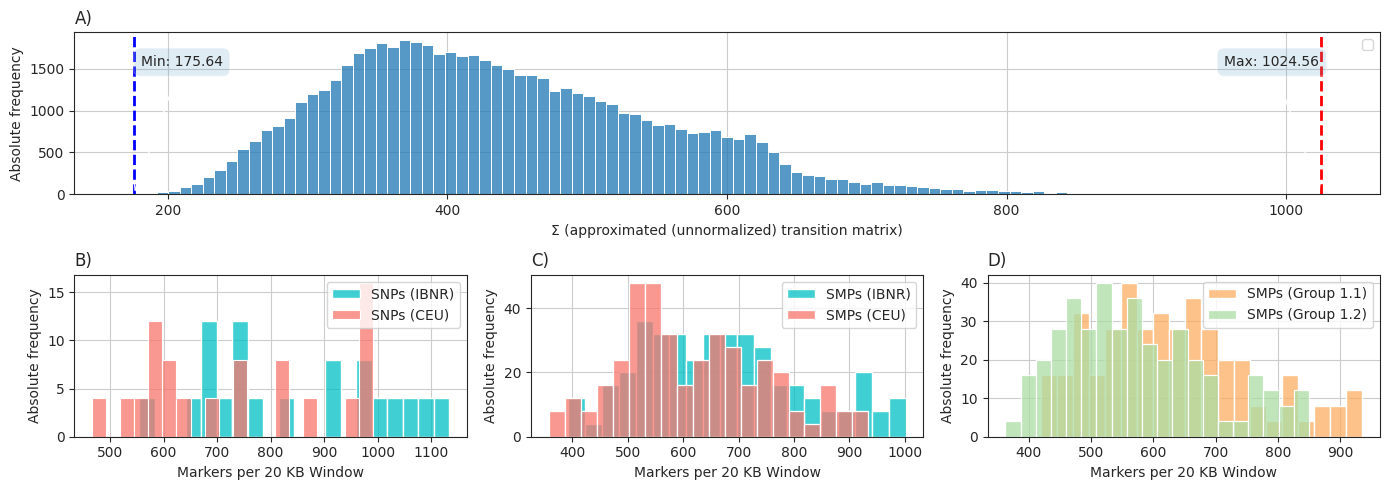

In [95]:
fig = plt.figure(figsize=(14, 5))
gs = fig.add_gridspec(2, 3)

# Top plot spanning all three columns
ax_top = fig.add_subplot(gs[0, :])
dataset = torch.load("./datasets/dataset_60k_window20k_L4_scaling3_diff.pth")
dataset = [(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) for X, y in dataset]
np.random.shuffle(dataset)
Xdist = [X.sum().item() for X, y in dataset]

max_value = max(Xdist)
min_value = min(Xdist)

sns.histplot(Xdist, ax=ax_top)

ax_top.axvline(x=max_value, color='red', linestyle='--', linewidth=2)
ax_top.axvline(x=min_value, color='blue', linestyle='--', linewidth=2)

ax_top.annotate(f'Max: {max_value:.2f}', xy=(max_value, 0), xytext=(-1, 90), 
                textcoords='offset points', ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='#64a0c8', alpha=0.2),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax_top.annotate(f'Min: {min_value:.2f}', xy=(min_value, 0), xytext=(5, 90), 
                textcoords='offset points', ha='left', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', fc='#64a0c8', alpha=0.2),
                arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

ax_top.grid()
ax_top.set_title("A)", loc="left")
ax_top.legend()
ax_top.set_ylabel("Absolute frequency")
ax_top.set_xlabel("Σ (approximated (unnormalized) transition matrix)")

# Bottom row plots
ax_bottom_left = fig.add_subplot(gs[1, 0])
sns.histplot(seq_samples_snp_ibnr, label="SNPs (IBNR)", ax=ax_bottom_left, bins=20, color="#00BFC4")
sns.histplot(seq_samples_snp_ceu, label="SNPs (CEU)", ax=ax_bottom_left, bins=20, color="#F8766D")
ax_bottom_left.set_title("B)", loc="left")
ax_bottom_left.grid()
ax_bottom_left.set_xlabel("Markers per 20 KB Window")
ax_bottom_left.set_ylabel("Absolute frequency")
ax_bottom_left.legend()

ax_bottom_middle = fig.add_subplot(gs[1, 1])
sns.histplot(seq_samples_ibnr, label="SMPs (IBNR)", ax=ax_bottom_middle, bins=20, color="#00BFC4")
sns.histplot(seq_samples_ceu, label="SMPs (CEU)", ax=ax_bottom_middle, bins=20, color="#F8766D")
ax_bottom_middle.set_title("C)", loc="left")
ax_bottom_middle.legend()
ax_bottom_middle.grid()
ax_bottom_middle.set_xlabel("Markers per 20 KB Window")
ax_bottom_middle.set_ylabel("Absolute frequency")

ax_bottom_right = fig.add_subplot(gs[1, 2])
sns.histplot(seq_samples_11, label="SMPs (Group 1.1)", ax=ax_bottom_right, bins=20, color="#FDAE61")
sns.histplot(seq_samples_12, label="SMPs (Group 1.2)", ax=ax_bottom_right, bins=20, color="#ABDDA4")
ax_bottom_right.set_title("D)", loc="left")
ax_bottom_right.legend()
ax_bottom_right.grid()
ax_bottom_right.set_xlabel("Markers per 20 KB Window")
ax_bottom_right.set_ylabel("Absolute frequency")

plt.tight_layout()
plt.savefig("distribution_matching_L4_2.pdf", dpi=400)

In [43]:
seq_samples_snp_ibnr = np.load("seq_samples_snp_ibnr.npy")
seq_samples_snp_ceu = np.load("seq_samples_snp_ceu.npy")

seq_samples_ibnr = np.load("seq_samples_ibnr.npy")
seq_samples_ceu = np.load("seq_samples_ceu.npy")

seq_samples_11 = np.load("seq_samples_11.npy")
seq_samples_12 = np.load("seq_samples_12.npy")

/tmp/ipykernel_450693/156186561.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("./datasets/dataset_60k_window20k_L4_scaling3_diff.pth")


Mean: 436.72


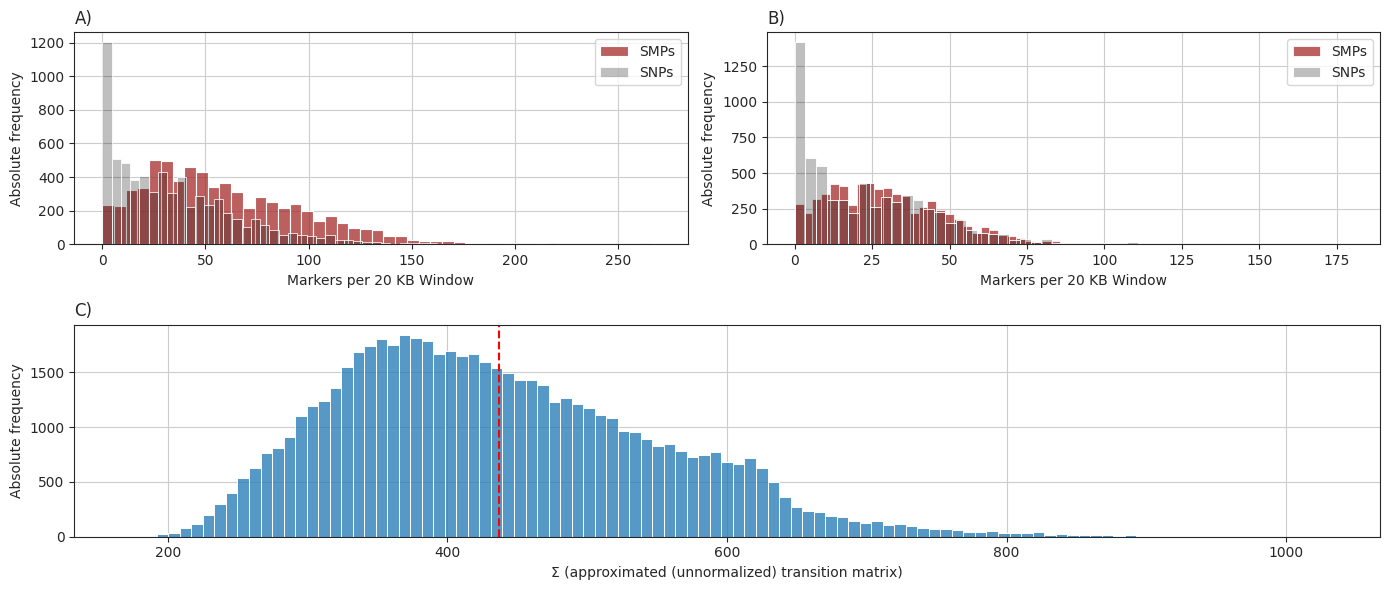

In [38]:
fig = plt.figure(figsize=(14, 6))

# Create a 2x2 grid
gs = fig.add_gridspec(2, 2)

# Top two plots
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(mutation_densities_smps_complete_ibnr, label="SMPs", ax=ax1, color="#a52a2a")
sns.histplot(mutation_densities_snps_complete_ibnr, color="black", label="SNPs", ax=ax1, alpha=0.25)
ax1.set_title("A)", loc="left", fontsize=12)
plt.xlabel("Markers per 20 KB Window")
plt.ylabel("Absolute frequency")

ax1.grid()
ax1.legend()

ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(mutation_densities_smps_complete_ceu, label="SMPs", ax=ax2, color="#a52a2a")
sns.histplot(mutation_densities_snps_complete_ceu, color="black", label="SNPs", ax=ax2, alpha=0.25)
ax2.set_title("B)", loc="left", fontsize=12)
plt.xlabel("Markers per 20 KB Window")
plt.ylabel("Absolute frequency")
ax2.legend()
ax2.grid()

# Bottom plot spanning both columns
ax3 = fig.add_subplot(gs[1, :])
dataset = torch.load("./datasets/dataset_60k_window20k_L4_scaling3_diff.pth")
dataset = [(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)) for X, y in dataset]
np.random.shuffle(dataset)
Xdist = [X.sum().item() for X, y in dataset]
sns.histplot(Xdist, ax=ax3)
ax3.axvline(np.mean(Xdist), color='r', linestyle='--')
ax3.grid()
ax3.set_title("C)", loc="left", fontsize=12)
plt.ylabel("Absolute frequency")
plt.xlabel("Σ (approximated (unnormalized) transition matrix)")



# Print the mean
print(f"Mean: {np.mean(Xdist):.2f}")

plt.tight_layout()
plt.savefig("distribution_matching_L4.pdf", dpi=400)

In [ ]:
flatten

In [19]:
import msprime
from aTMi.processing import obtain_mutation_densities
from scipy.interpolate import interp1d



def create_sawtooth_demogaphy_object(Ne = 10**4, magnitue=2):
    
    demography = msprime.Demography()
    demography.add_population(initial_size=(Ne))
    demography.add_population_parameters_change(time=20, population=None,growth_rate=6437.7516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=30, growth_rate=-378.691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=200, growth_rate=-643.77516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=300, growth_rate=37.8691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=2000, growth_rate=64.377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=3000, growth_rate=-3.78691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=20000, growth_rate=-6.4377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=30000, growth_rate=0.378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=200000, growth_rate=0.64377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=300000, growth_rate=-0.0378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=2000000, growth_rate=-0.064377516497364/(magnitue*10**4))
    demography.add_population_parameters_change(time=3000000, growth_rate=0.00378691273513906/(magnitue*10**4))
    demography.add_population_parameters_change(time=20000000, growth_rate=0,initial_size=Ne)
    return demography

def interpolate_tmrca_per_window(position, tmrca, interval_start = 0, interval_end = 500_000, interval_size = 2000):
    """ Calculates sum tmrca estimate, when given the position and the tmrca """
    x_points = position
    y_points = tmrca
    interp_function = interp1d(x_points, y_points, kind='previous', fill_value="extrapolate")
    intervals = np.arange(interval_start, interval_end, interval_size)
    averages = []
    for i in range(len(intervals)-1):
        start = intervals[i] 
        end = intervals[i + 1]
        x_vals = np.linspace(start, end, 100)  # More points for better accuracy
        y_vals = interp_function(x_vals)
        average = np.mean(y_vals)
        averages.append(average)
    return np.array(averages)

def get_interpolated_tmrca_landscape(ts, window_size):

    tmrca_landscape = []
    for tree in ts.trees():
        left = tree.interval.left
        right = tree.interval.right
        node = [node for node in tree.nodes() if node not in [0, 1]][0]
        tmrca = tree.time(node)
        tmrca_landscape.append((left, right, node, tmrca))
    tmrca_landscape = np.array(tmrca_landscape)

    y_tmrca_interpolated = interpolate_tmrca_per_window(
        tmrca_landscape[:, 0],
        tmrca_landscape[:, 3], interval_end=int(ts.sequence_length)+window_size, interval_size=window_size
    )

    return y_tmrca_interpolated



In [20]:
def plot_methylation_figure(counts, tmrcas, ax):

    log_counts = np.log(1+counts)
    log_tmrcas = np.log(1+tmrcas)

    ax.plot([0, 13.5], [0, 13.5])
    sns.set_style("ticks")

    hexbin = ax.hexbin(log_counts, log_tmrcas, gridsize=100, cmap='viridis', 
                    mincnt=1, bins='log')  # Use logarithmic binning

    ax.set_xlabel('Log(#Marker)', fontsize=12)
    ax.set_ylabel('Log(TMRCAs)', fontsize=12)

    ax.tick_params(labelsize=14)
    
    cbar = fig.colorbar(hexbin, ax=ax, label='Count in bin (log scale)')
    cbar.set_label('Count in bin (log scale)', fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    cbar.set_label('Count in window (log scale)', fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    ax.grid(True)
    ax.set_xlim([1, 13.5])
    ax.set_ylim([9, 13.5])


#debugger = msprime.DemographyDebugger()
#debugger = msprime.DemographyDebugger(demography=sawtooth_demography_object)

sawtooth_demography_object = create_sawtooth_demogaphy_object(Ne = 2*10**5)
params = {
        'discrete_genome': True,
        'samples': 2, 
        'ploidy': 1,
        'demography': sawtooth_demography_object,
        'recombination_rate': 3.4e-8,
        'random_seed': seed,
        'sequence_length': 10_000_000
    }

In [21]:
seed = 1000


params = {
        'discrete_genome': True,
        'samples': 2, 
        'ploidy': 1,
        'population_size': 2*10**5,
        'recombination_rate': 3.4e-8,
        'random_seed': seed,
        'sequence_length': 4_000_000
    }


ts = msprime.sim_ancestry(**params)
ts = msprime.mutate(ts, rate=7e-9, random_seed=seed)

window_size = 20_000
empirical_scaling_factor = 3
mutation_densities = obtain_mutation_densities(ts, window_size=window_size)#.flatten()

In [333]:
#sns.set(font_scale=1.5, style="whitegrid")

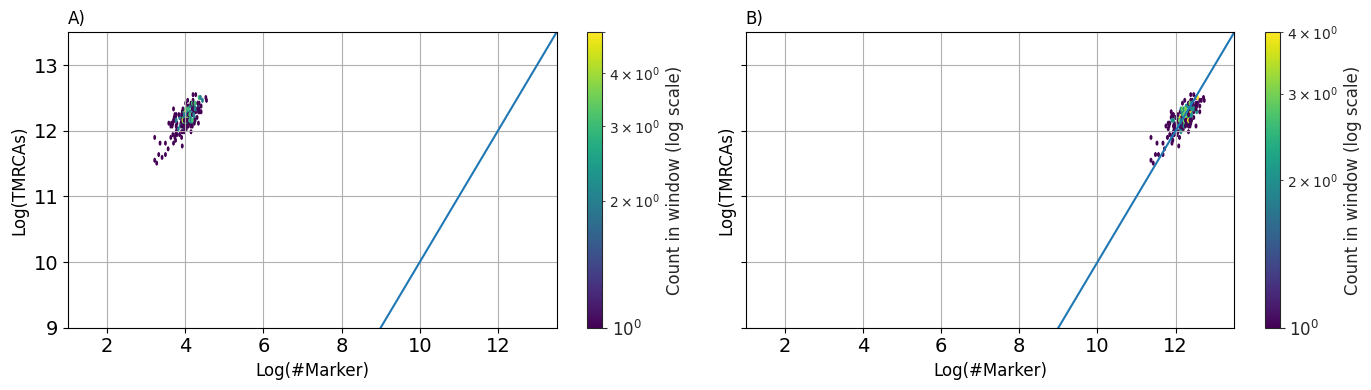

In [22]:
def plot_methylation_figure(counts, tmrcas, ax):

    log_counts = np.log(1+counts)
    log_tmrcas = np.log(1+tmrcas)

    ax.plot([0, 13.5], [0, 13.5])
    sns.set_style("ticks")

    hexbin = ax.hexbin(log_counts, log_tmrcas, gridsize=100, cmap='viridis', 
                    mincnt=1, bins='log')  # Use logarithmic binning

    ax.set_xlabel('Log(#Marker)', fontsize=12)
    ax.set_ylabel('Log(TMRCAs)', fontsize=12)

    ax.tick_params(labelsize=14)
    
    cbar = fig.colorbar(hexbin, ax=ax, label='Count in bin (log scale)')
    cbar.set_label('Count in bin (log scale)', fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    cbar.set_label('Count in window (log scale)', fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    ax.grid(True)
    ax.set_xlim([1, 13.5])
    ax.set_ylim([9, 13.5])


#debugger = msprime.DemographyDebugger()
#debugger = msprime.DemographyDebugger(demography=sawtooth_demography_object)

sawtooth_demography_object = create_sawtooth_demogaphy_object(Ne = 2*10**5)
params = {
        'discrete_genome': True,
        'samples': 2, 
        'ploidy': 1,
        'demography': sawtooth_demography_object,
        'recombination_rate': 3.4e-8,
        'random_seed': seed,
        'sequence_length': 10_000_000
    }


# gridsize 100
window_size = 20_000
empirical_scaling_factor = 3
mutation_densities = obtain_mutation_densities(ts, window_size=window_size)#.flatten()
binary_ts = ts.simplify(samples=[0, 1])
tmrcas = get_interpolated_tmrca_landscape(binary_ts, window_size=window_size)

fig, axs = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
plot_methylation_figure(mutation_densities, tmrcas, ax=axs[0])
axs[0].set_title("A)", loc="left", fontsize=12)
#axs[0].tick_params(top=True, right=True, direction='in')
#plt.gca().spines['top'].set_visible(True)
#plt.gca().spines['right'].set_visible(True)

window_size = 20_000
empirical_scaling_factor = 3
mutation_densities = obtain_mutation_densities(ts, window_size=window_size)#.flatten()
binary_ts = ts.simplify(samples=[0, 1])
tmrcas = get_interpolated_tmrca_landscape(binary_ts, window_size=window_size)
plot_methylation_figure(mutation_densities*np.exp(8.2), tmrcas,  ax=axs[1])
axs[1].set_title("B)", loc="left" , fontsize=12)

plt.tight_layout()
#axs[1].tick_params(top=True, right=True, direction='in')
#plt.gca().spines['top'].set_visible(True)
#plt.gca().spines['right'].set_visible(True)

plt.savefig("scaling_factor_4mb.pdf", dpi=400)